Our spatial model doesn't seem to be powerful enough. I suspect we're underestimating spatial correlations. Let's compare the covariance function of our model to empirical correlations between the 4 stations in Iowa.

In [1]:
using TimeSeries
using DataFrames
using DataFrames: head, groupby
using GaussianProcesses
using GaussianProcesses: Mean, Kernel, evaluate, metric, IsotropicData, VecF64
using GaussianProcesses: Stationary, KernelData, MatF64
import GaussianProcesses: optimize!, get_optim_target, cov, grad_slice!
import GaussianProcesses: num_params, set_params!, get_params, update_mll!, update_mll_and_dmll!
import GaussianProcesses: get_param_names, cov!, addcov!, multcov!
import Proj4
using Optim
using Distances
using Base.Dates
using StatsBase
;

In [2]:
import PyPlot; plt=PyPlot
using LaTeXStrings
plt.rc("figure", dpi=300.0)
# plt.rc("figure", figsize=(6,4))
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

In [3]:
include("iowa.jl")

iowa = prepare_iowa_data(data_dir);

# Variogram

In [4]:
numstations = 4

4

In [5]:
sqdiff_accum = zeros(Float64, numstations, numstations)
npairs = zeros(Int, numstations, numstations)
by_hour = groupby(iowa[:hourly_data], :hour)
for simult in by_hour
    for i in 1:nrow(simult)
        for j in 1:i-1
            station_i = simult[i,:station]
            station_j = simult[j,:station]

            temp_i = simult[i,:temp]
            temp_j = simult[j,:temp]

            sqdiff_accum[station_i,station_j] += (temp_i-temp_j)^2
            sqdiff_accum[station_j,station_i] += (temp_i-temp_j)^2
            npairs[station_i,station_j] += 1
            npairs[station_j,station_i] += 1
        end
    end
end

In [6]:
vargrid = sqdiff_accum ./ (npairs.*2)

4×4 Array{Float64,2}:
 0.191261  4.43257   1.868     4.99088 
 4.43257   0.142557  4.96368   7.68208 
 1.868     4.96368   0.174391  2.05267 
 4.99088   7.68208   2.05267   0.163581

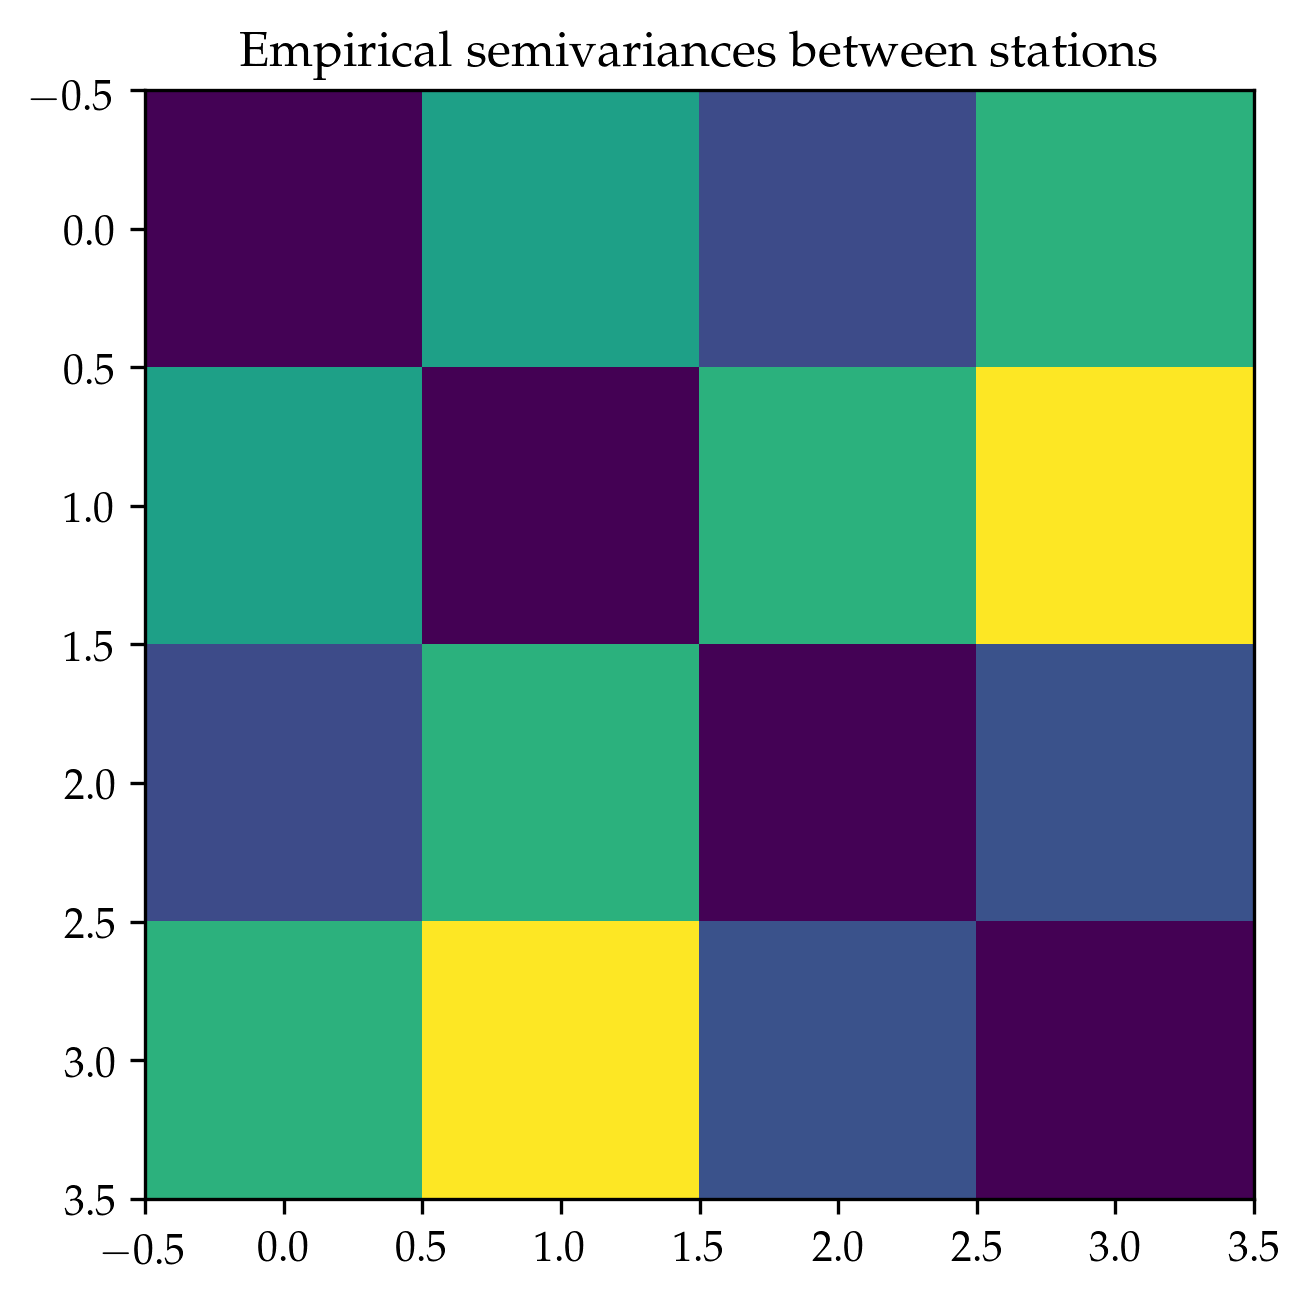

PyObject Text(0.5,1,'Empirical semivariances between stations')

In [7]:
plt.imshow(vargrid, interpolation="nearest")
plt.title("Empirical semivariances between stations")

Let's plot the empirical semi-variances as a function of the distance between pairs of stations, and compare that to the variogram of our fitted spatiotemporal kernel.

# Kernels

In [8]:
using GaussianProcesses: RQIso, SEIso, set_params!, Masked

## Product of SE

In [9]:
k_spatiotemporal, logNoise = TempModel.fitted_sptemp_SExSE(;kmean=false)
gp_SESE = GPE(;m=MeanZero(), k=k_spatiotemporal, logNoise=logNoise);

## diurnal

In [10]:
k_spatiotemporal, logNoise = TempModel.fitted_sptemp_diurnal(;kmean=false)
gp_diurnal = GPE(;m=MeanZero(), k=k_spatiotemporal, logNoise=logNoise);

## Single spatial decay

In [11]:
# Temporal
k1 = fix(Periodic(0.0,0.0,log(24.0)), :lp)
k2 = RQIso(0.0,0.0,0.0)
k3 = SEIso(0.0,0.0)
k4 = RQIso(0.0,0.0,0.0)
k5 = RQIso(0.0,0.0,0.0)
k6 = SEIso(0.0,0.0)
k_time=k1+k2+k3+k4+k5+k6
# hyperparameters fitted in JuliaGP_timeseries_chunks.ipynb
hyp=[-1.4693,-0.0806483,1.0449,1.50786,1.10795,-1.38548,-1.22736,-1.05138,3.09723,1.28737,2.84127,3.64666,0.469691,3.00962,7.70695,-5.39838]
set_params!(k_time, hyp[2:end])

# Spatial
k_spatial = SEIso(log(2*10^5), log(1.0))
hyp=[-1.5875,11.2445,0.132749]
set_params!(k_spatial, hyp[2:3])
logNoise=hyp[1]
k_spatiotemporal = Masked(k_time, [1]) * Masked(k_spatial, [2,3])

Type: GaussianProcesses.ProdKernel
  Type: GaussianProcesses.Masked{GaussianProcesses.SumKernel}, Params: [-0.0806483, 1.0449, 1.50786, 1.10795, -1.38548, -1.22736, -1.05138, 3.09723, 1.28737, 2.84127, 3.64666, 0.469691, 3.00962, 7.70695, -5.39838]
  Type: GaussianProcesses.Masked{GaussianProcesses.SEIso}, Params: [11.2445, 0.132749]


In [12]:
gp_sumSE = GPE(;m=MeanZero(), k=k_spatiotemporal, logNoise=logNoise);

In [13]:
print("k₁: Periodic \n=================\n")
@printf("σ: %5.3f\n", √k1.kern.σ2)
@printf("l: %5.3f\n", √k1.kern.ℓ2)
@printf("p: %5.0f hours\n", k1.kern.p)

k₁: Periodic 
σ: 2.843
l: 0.923
p:    24 hours


## Sum of products: fixed variances

In [14]:
k_spatiotemporal, logNoise = TempModel.fitted_sptemp_fixedvar(;kmean=false)
gp_fixedvar = GPE(;m=MeanZero(), k=k_spatiotemporal, logNoise=logNoise);

## with free variances

In [15]:
k_spatiotemporal, logNoise = TempModel.fitted_sptemp_freevar(;kmean=false)
gp_freevar = GPE(;m=MeanZero(), k=k_spatiotemporal, logNoise=logNoise);

## fully free

In [16]:
k_spatiotemporal, logNoise = TempModel.fitted_sptemp_sumprod(;kmean=false)
gp_sumprod = GPE(;m=MeanZero(), k=k_spatiotemporal, logNoise=logNoise);

## simplified

In [17]:
k_spatiotemporal, logNoise = TempModel.fitted_sptemp_simpler(;kmean=false)
gp_simpler = GPE(;m=MeanZero(), k=k_spatiotemporal, logNoise=logNoise);

# Spatial variogram

In [18]:
pairwiseEuclid=pairwise(Euclidean(), Matrix(iowa[:isdSubset][[:X_PRJ,:Y_PRJ]])')

4×4 Array{Float64,2}:
      0.0        165736.0        93510.4        1.93474e5
 165736.0             0.0            1.53559e5  1.81942e5
  93510.4             1.53559e5      0.0        1.00846e5
      1.93474e5       1.81942e5      1.00846e5  0.0      

In [19]:
function spatial_variog(gp::GPE, rr::AbstractVector)
    ck_spt = [cov(gp.k, [0.0,r,0.0], [0.0,0.0,0.0]) for r in rr]
    return exp(2.0*gp.logNoise)+ck_spt[1].-ck_spt
end 

spatial_variog (generic function with 1 method)

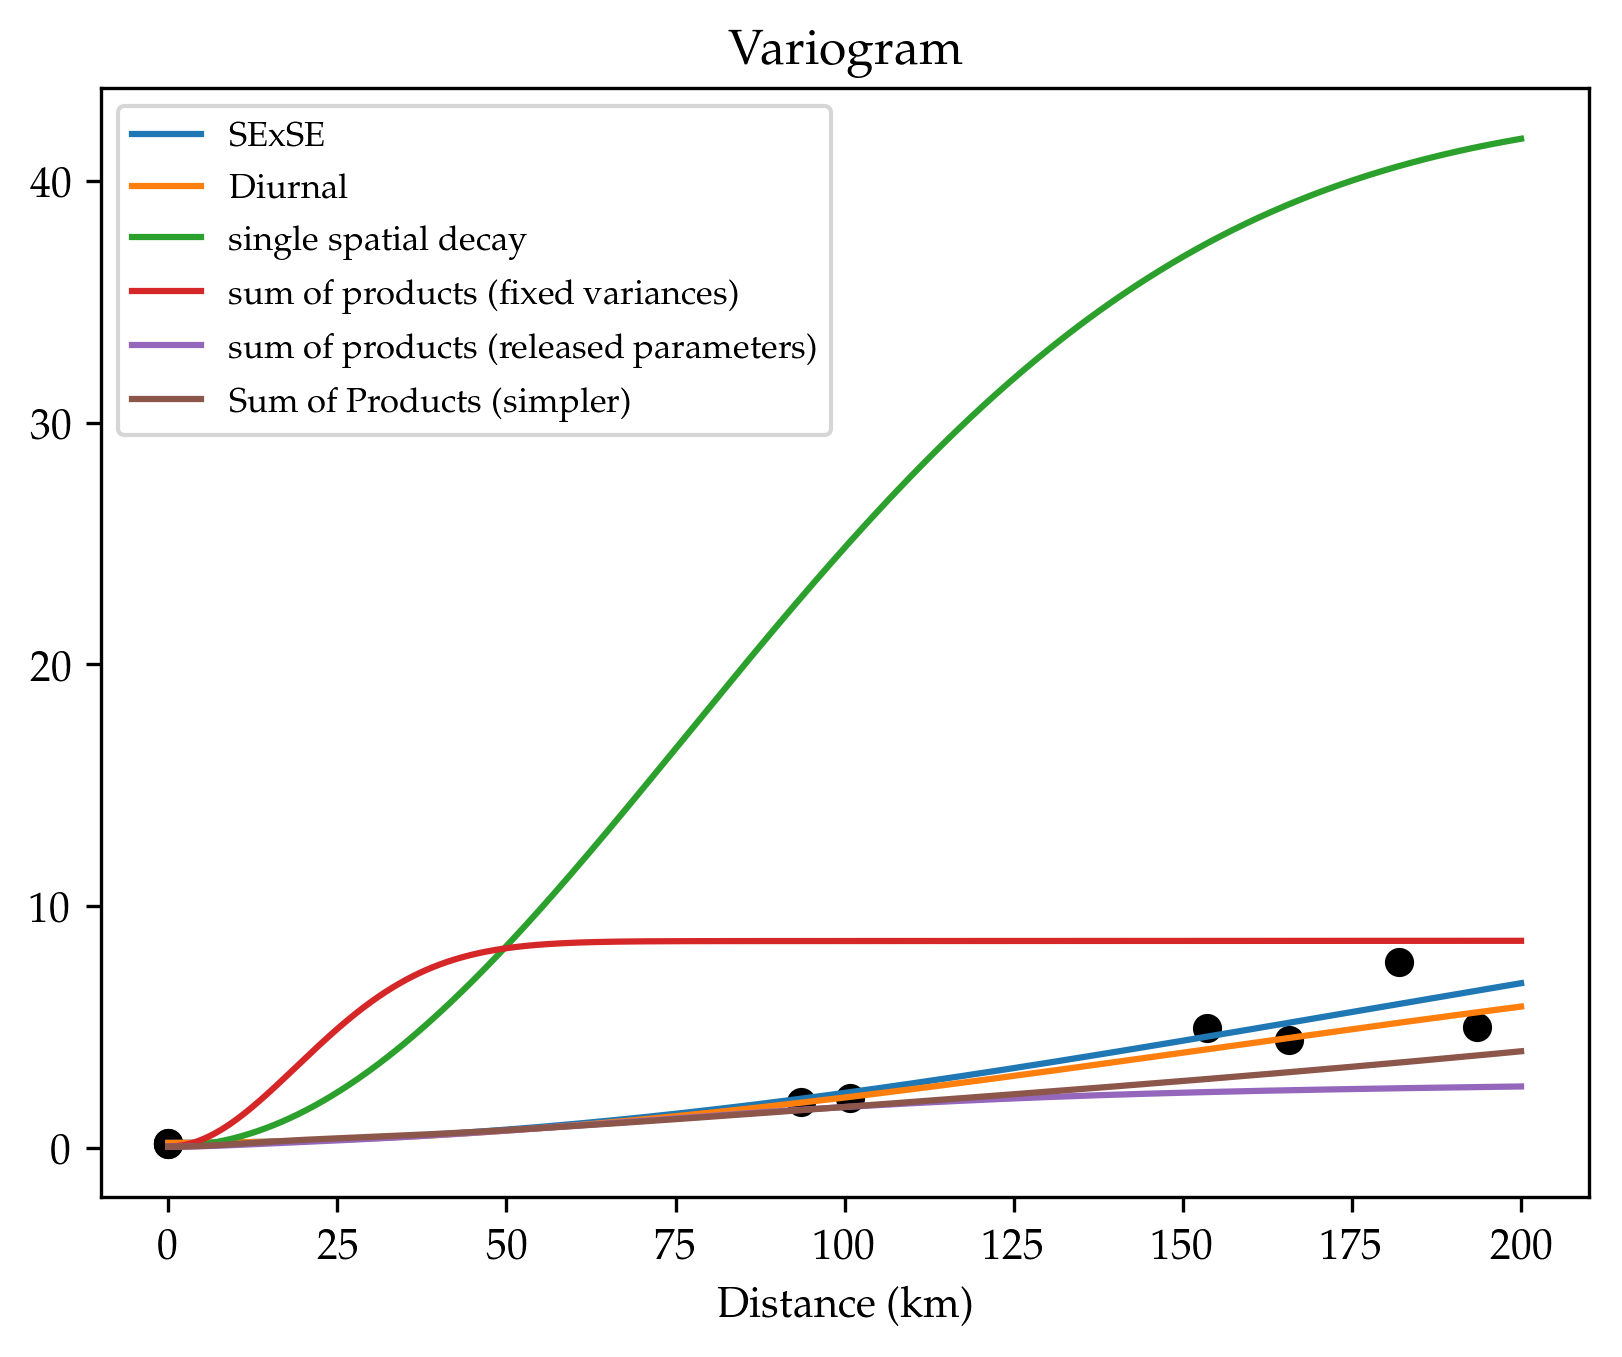

PyObject <matplotlib.legend.Legend object at 0x12e5219b0>

In [20]:
begin
    for i in 1:numstations
        for j in 1:i
            plt.plot(pairwiseEuclid[i,j]./1000, vargrid[i,j], "o", color="black")
        end
    end
    rr = linspace(0.0, 200000.0, 1000)
    plt.plot(rr./1000, spatial_variog(gp_SESE, rr), label="SExSE")
    plt.plot(rr./1000, spatial_variog(gp_diurnal, rr), label="Diurnal")
    plt.plot(rr./1000, spatial_variog(gp_sumSE, rr), label="single spatial decay")
    plt.plot(rr./1000, spatial_variog(gp_fixedvar, rr), label="sum of products (fixed variances)")
    plt.plot(rr./1000, spatial_variog(gp_sumprod, rr), label="sum of products (released parameters)")
    plt.plot(rr./1000, spatial_variog(gp_simpler, rr), label="Sum of Products (simpler)")
    plt.xlabel("Distance (km)")
    plt.title("Variogram")
    plt.legend(loc="upper left", fontsize="small")
end

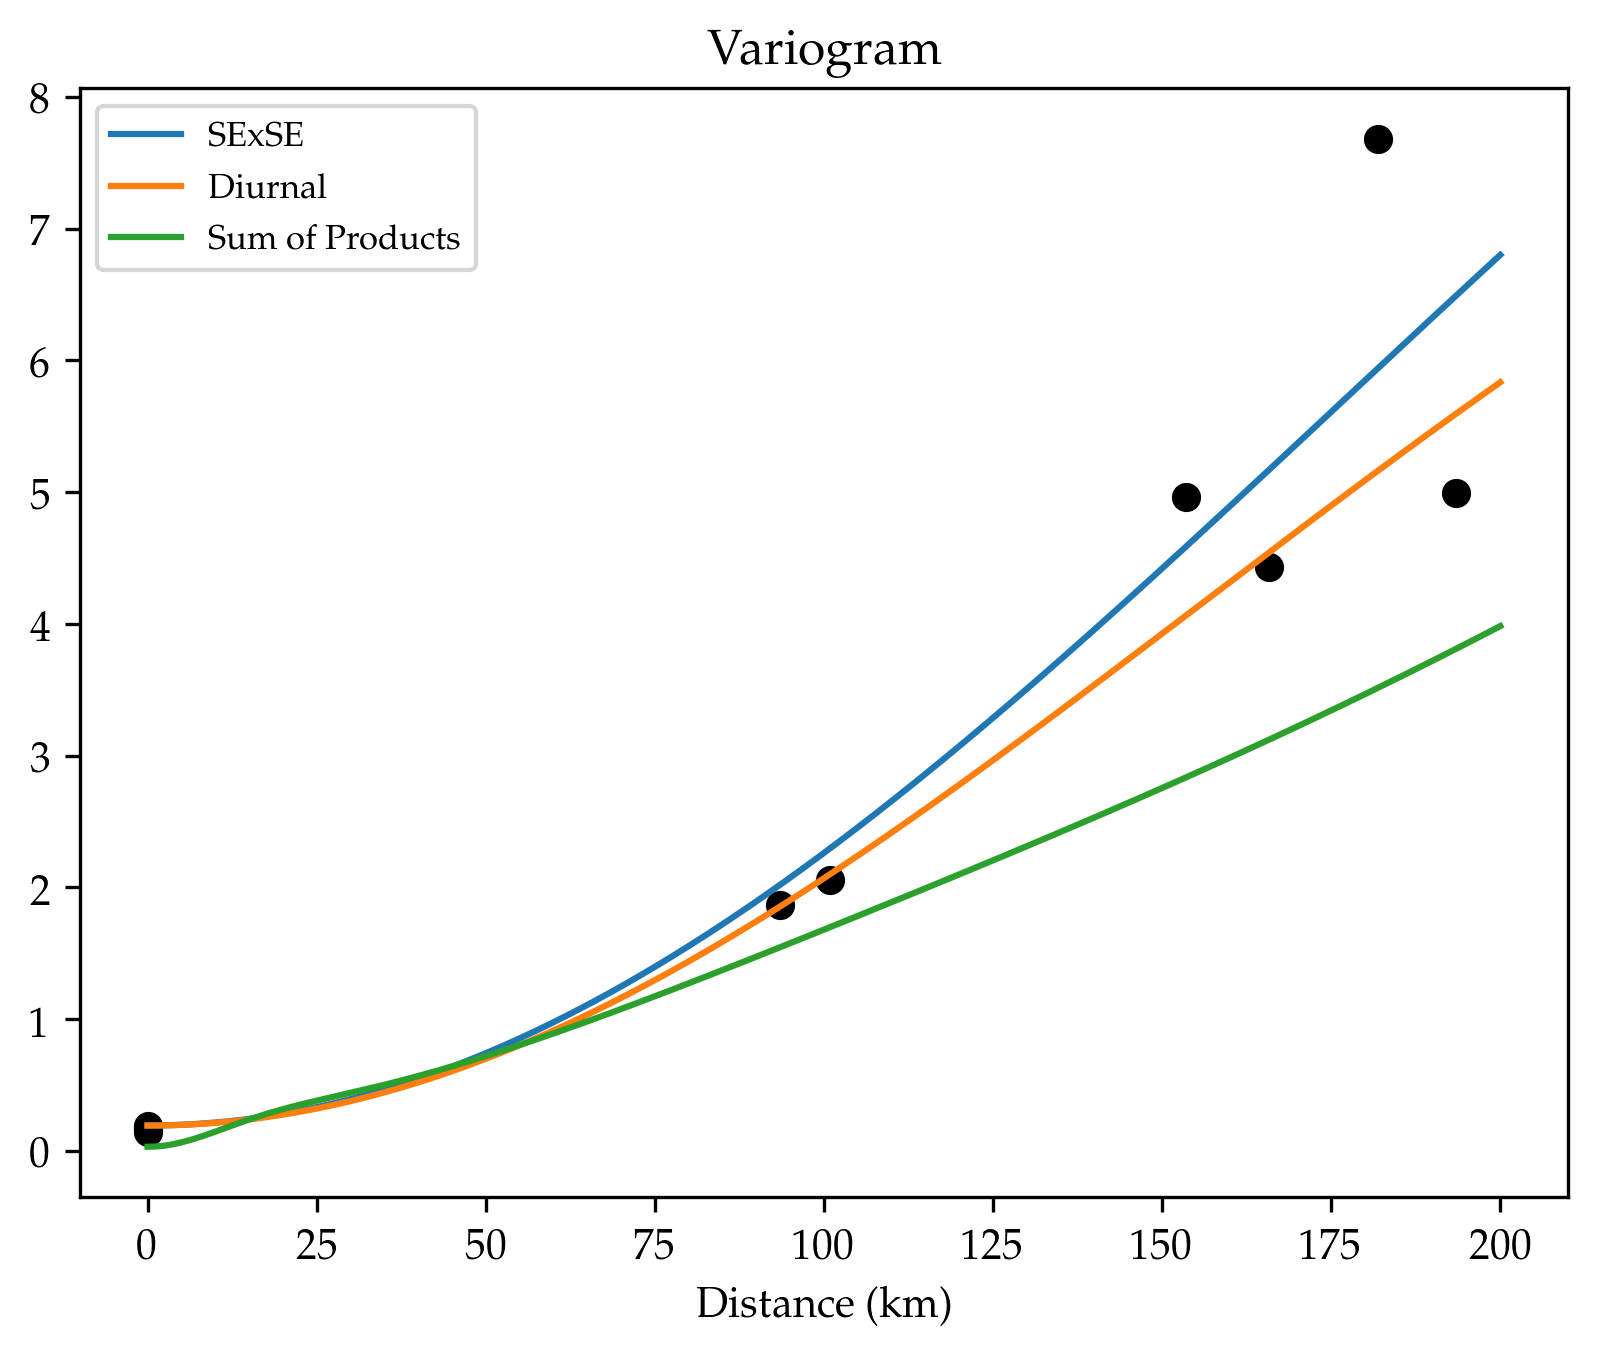

PyObject <matplotlib.legend.Legend object at 0x12e6626a0>

In [21]:
begin
    for i in 1:numstations
        for j in 1:i
            plt.plot(pairwiseEuclid[i,j]./1000, vargrid[i,j], "o", color="black")
        end
    end
    rr = linspace(0.0, 200000.0, 1000)
    plt.plot(rr./1000, spatial_variog(gp_SESE, rr), label="SExSE")
    plt.plot(rr./1000, spatial_variog(gp_diurnal, rr), label="Diurnal")
#     plt.plot(rr./1000, spatial_variog(gp_sumSE, rr), label="single spatial decay")
#     plt.plot(rr./1000, spatial_variog(gp_fixedvar, rr), label="sum of products (fixed variances)")
#     plt.plot(rr./1000, spatial_variog(gp_sumprod, rr), label="sum of products (released parameters)")
    plt.plot(rr./1000, spatial_variog(gp_simpler, rr), label="Sum of Products")
    plt.xlabel("Distance (km)")
    plt.title("Variogram")
    plt.legend(loc="upper left", fontsize="small")
end

As I suspected, the single spatial decay kernel is not a good fit for the empirical variogram. Two possible explanations spring to mind:
1. the optimization algorithm of the spatial kernel got stuck in a local maximum (of the marginal likelihood)
2. the product kernel specification is too restrictive, it is forcing the model to underestimate the spatial correlations

# Grid variogram

## Empirical cross-variogram

In [22]:
timebins=Hour(0):Hour(2):Hour(30*24)
nbins=length(timebins)

361

In [23]:
group_stations = groupby(iowa[:hourly_data], :station)

function cross_variog(station_i::Int, station_j::Int, timebins::AbstractVector)
    data_i = group_stations[station_i]
    data_j = group_stations[station_j]
    times_i = data_i[:ts]
    times_j = data_j[:ts]
    temp_i = data_i[:temp]
    temp_j = data_j[:temp]
    return TempModel.cross_variog(times_i, times_j, temp_i, temp_j, timebins)
end
;

**Obtain empirical cross-variograms between pairs of stations**

In [37]:
all_cross_variogs = Array(TempModel.Variogram, 4, 4)
@time for station_i in 1:4
    for station_j in station_i:4
        v=cross_variog(station_i, station_j, timebins)
        all_cross_variogs[station_i, station_j] = v
    end
end

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] Array(::Type{TempModel.Variogram}, ::Int64, ::Int64) at ./deprecated.jl:57
 [3] include_string(::String, ::String) at /Users/imolk/bin/julia_v0.6.2_binary/lib/julia/sys.dylib:?
 [4] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /Users/imolk/Library/Julia/packages_experimental/v0.6/IJulia/src/execute_request.jl:158
 [5] (::Compat.#inner#18{Array{Any,1},IJulia.#execute_request,Tuple{ZMQ.Socket,IJulia.Msg}})() at /Users/imolk/Library/Julia/packages_experimental/v0.6/Compat/src/Compat.jl:386
 [6] eventloop(::ZMQ.Socket) at /Users/imolk/Library/Julia/packages_experimental/v0.6/IJulia/src/eventloop.jl:8
 [7] (::IJulia.##14#17)() at ./task.jl:335
while loading In[37], in expression starting on line 1


249.890686 seconds (3.93 G allocations: 58.522 GiB, 4.35% gc time)


## Plots

In [48]:
cbbPalette = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
;

""" Given a spatio-temporal kernel, 
    compute the variogram along the time axis for a given distance.
"""
function time_variog(gp::GPE, rr::AbstractVector, dist::Float64)
    fitted_cov = [cov(gp.k, [0.0,0.0,0.0], [r,dist,0.0]) for r in rr]
    k00 = cov(gp.k, [0.0,0.0,0.0], [0.0,0.0,0.0])
    return exp(2.0*gp.logNoise).+k00.-fitted_cov
end

function plot_variogram_grid(isdSubset, xlim, xticks, ylim, yticks; xdivider::Float64=24.0, xunit::String="days", lastyticks::Bool=false, lastxticks::Bool=false)
    local h
    local l
    for station_i in 1:4
        for station_j in station_i:4
            v=all_cross_variogs[station_i,station_j]
            plt.subplot(4,4,(station_i-1)*4+station_j)
            y = TempModel.variog(v)
            x = v.bins ./ Dates.Hour(1) # x in hours
            d = pairwiseEuclid[station_i,station_j]
            xx = minimum(x):0.1:maximum(x)
            σy2 = exp(2.0*logNoise)
            plt.plot(x./xdivider, y, color="black", label="Empirical", alpha=0.7, zorder=11)
            plt.plot(x./xdivider, time_variog(gp_SESE, x, d), color=cbbPalette[2], label=L"k_{\mathtt{SExSE}}", zorder=10)
            plt.plot(x./xdivider, time_variog(gp_diurnal, x, d), color=cbbPalette[4], label=L"k_{\mathtt{SESE_{24}}}", zorder=8)
            plt.plot(x./xdivider, time_variog(gp_simpler, x, d), color=cbbPalette[3], label=L"k_{\mathtt{sumprod}}", zorder=9)
            plt.xlim(xlim)
            plt.ylim(ylim)
            if station_i == 1
                plt.title(isdSubset[station_j, :ICAO], fontsize="small")
            end
            if station_j == 4
                plt.ylabel(isdSubset[station_i, :ICAO], fontsize="small")
                plt.gca()[:yaxis][:set_label_position]("right")
            end
            if station_i == station_j
                plt.xlabel(@sprintf("Lag (%s)", xunit))
#                 plt.ylabel("Variogram")
                ax = plt.gca()
                if lastyticks
                    ytick_labels = yticks
                else
                    ytick_labels = yticks[1:end-1]
                end
                if lastxticks
                    xtick_labels = xticks
                else
                    xtick_labels = xticks[1:end-1]
                end
                plt.xticks(xticks, xtick_labels)
                plt.yticks(yticks, ytick_labels)
    #             ax[:set_xticks](collect(minimum(x):maximum(x)))
            else
                ax = plt.gca()
                plt.xticks(xticks, [])
                plt.yticks(yticks, [])
            end
            if station_i == 1 & station_j == 1
                h, l = plt.gca()[:get_legend_handles_labels]()
            end
            plt.ylim(ylim)
        end
    end
    plt.subplot(4,4,14)
    plt.gca()[:axis]("off")
    plt.legend(h,l,loc="upper right", fontsize="small", title="Variograms")
end 
;

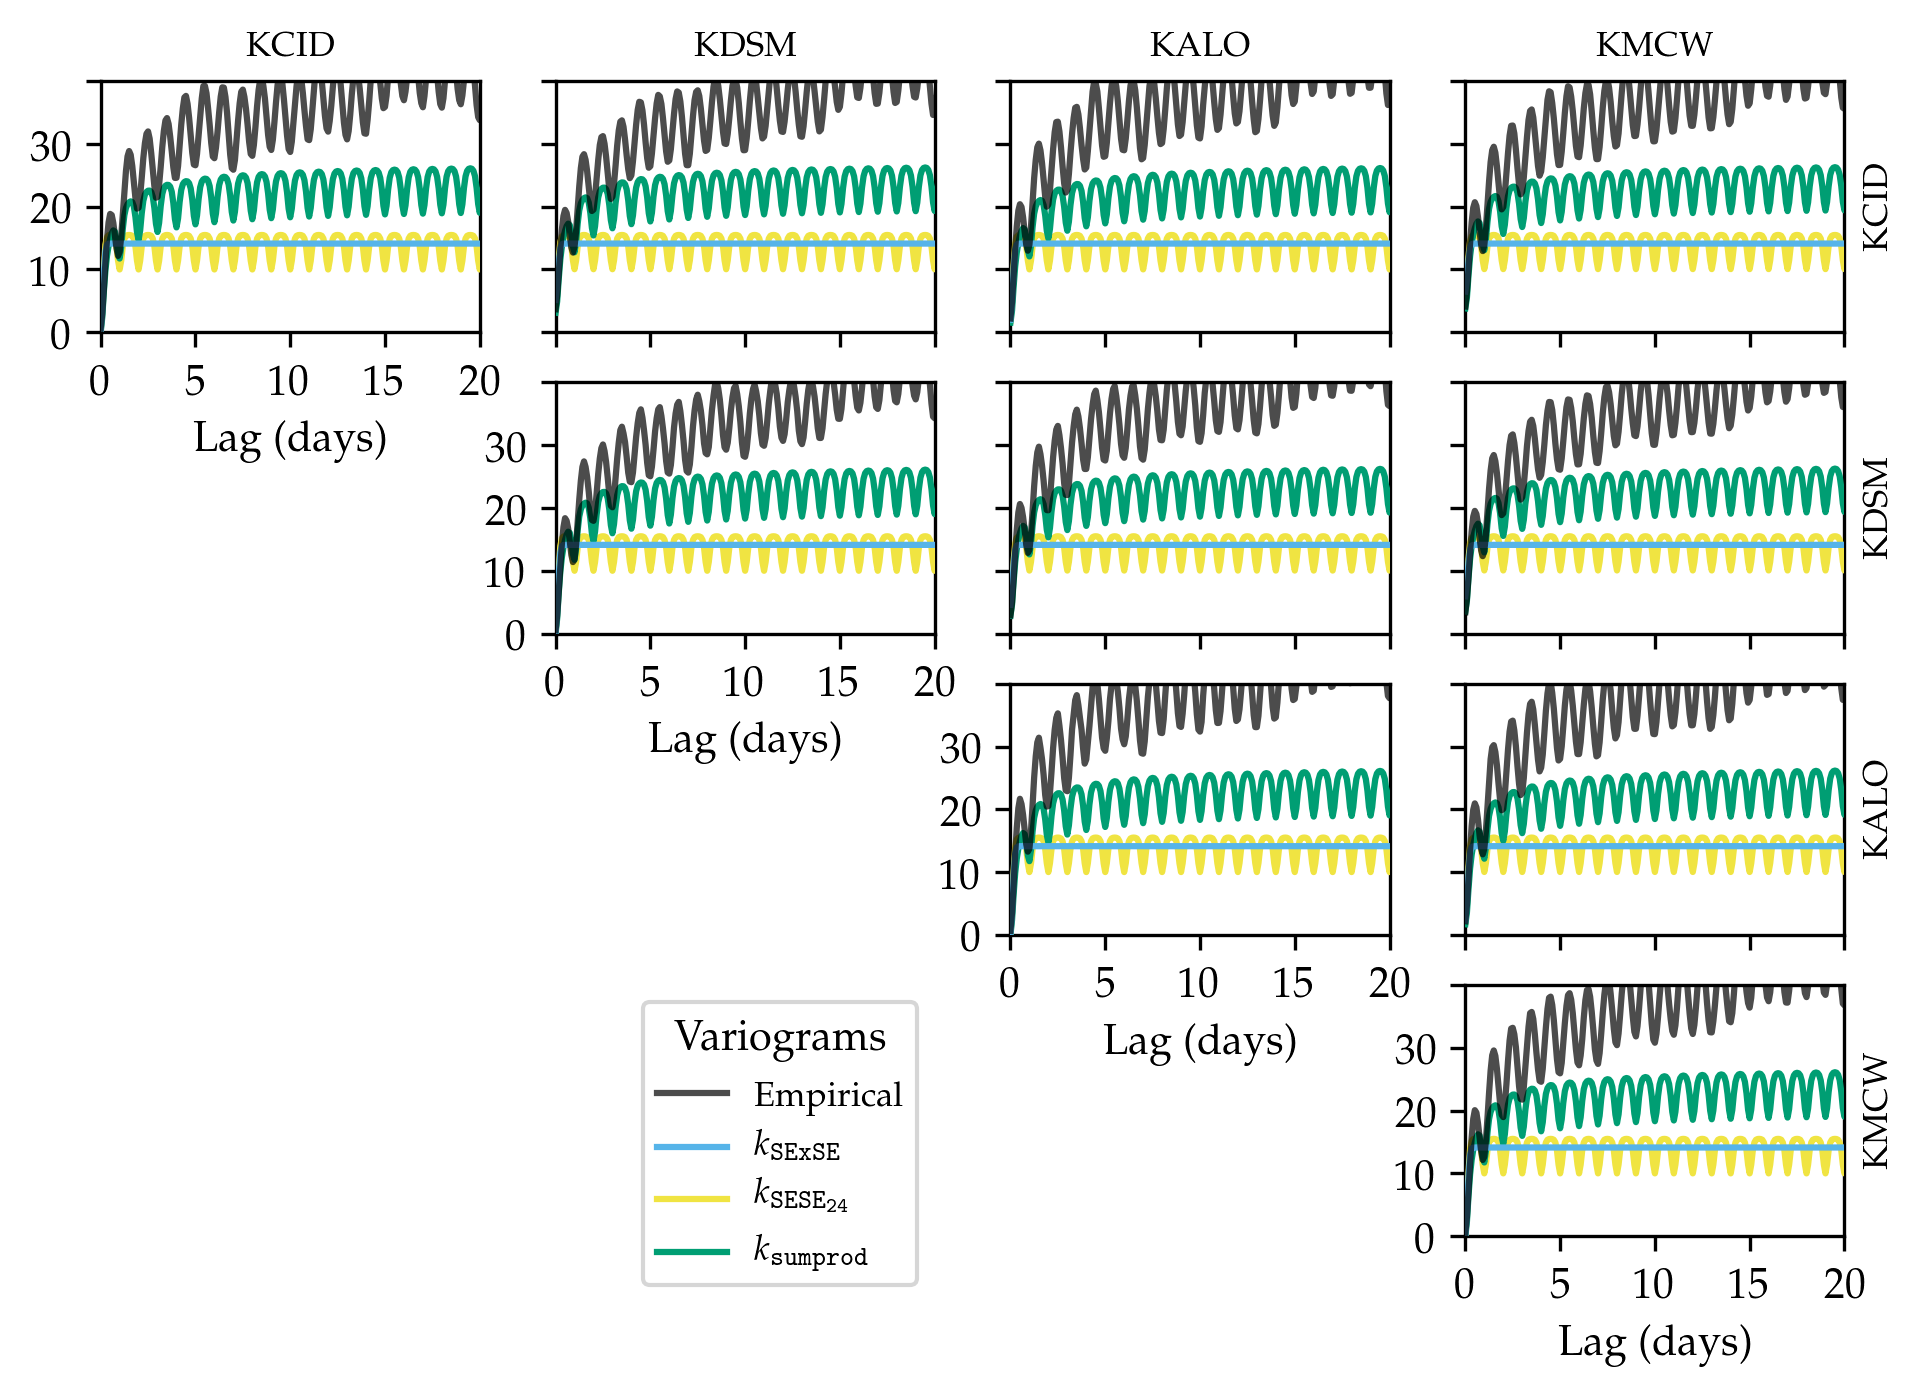

In [49]:
plot_variogram_grid(
    iowa[:isdSubset],
    (0,20), (0, 5, 10, 15, 20), 
    (0, 40), [0, 10, 20, 30, 40]; 
    xdivider=24.0, xunit="days", lastyticks=false, lastxticks=true)
plt.gcf()[:set_size_inches](7.5, 5.0)
;

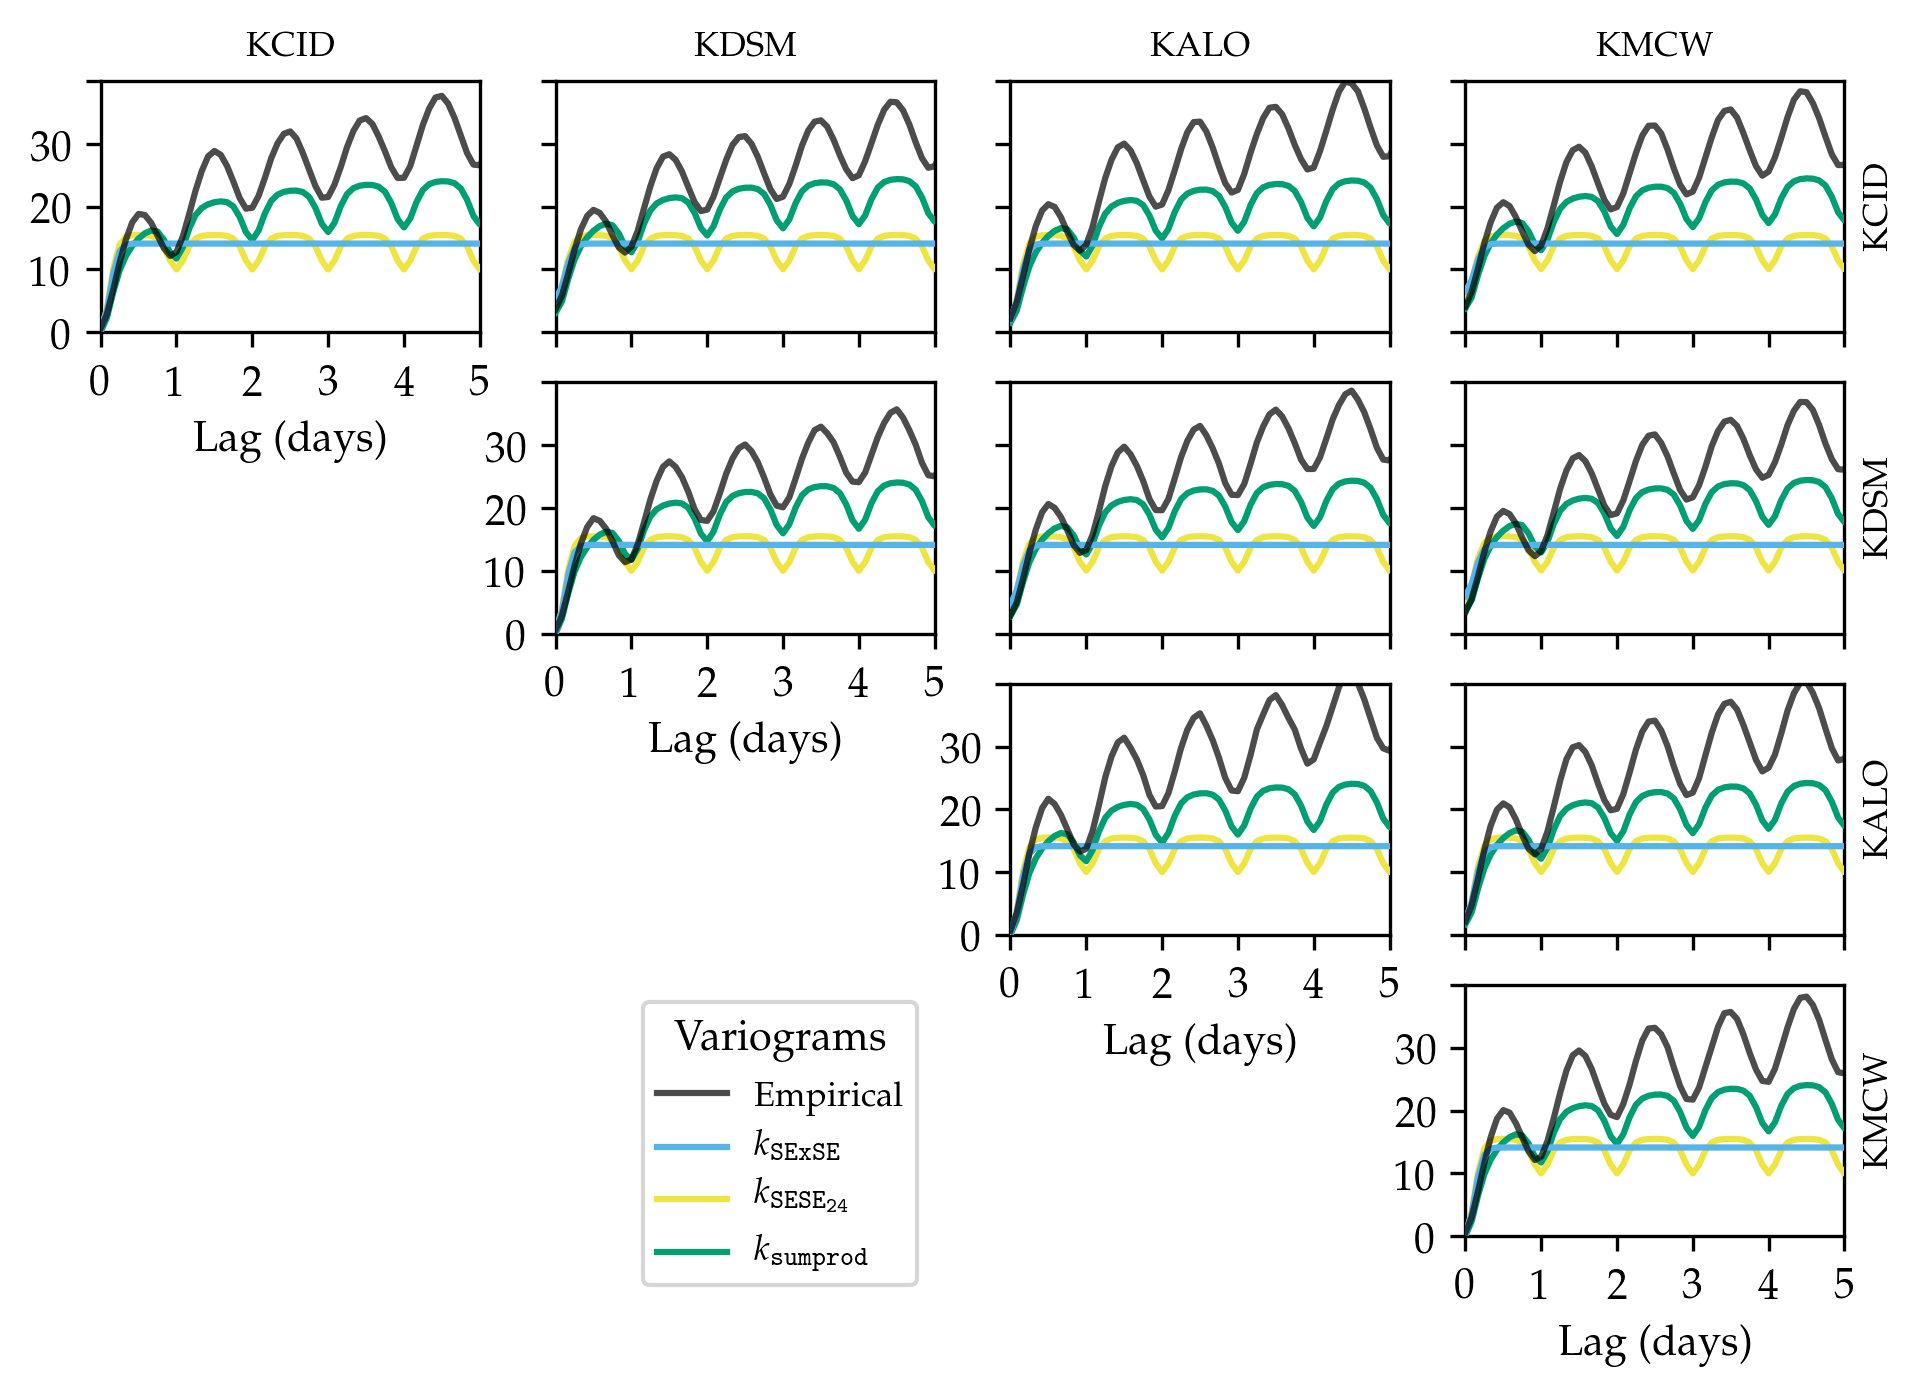

In [51]:
plot_variogram_grid(
    iowa[:isdSubset],
    (0,5), 0:5, 
    (0, 40), 0:10:40; 
    xdivider=24.0, xunit="days", lastyticks=false, lastxticks=true)
plt.gcf()[:set_size_inches](7.5, 5.0)
;

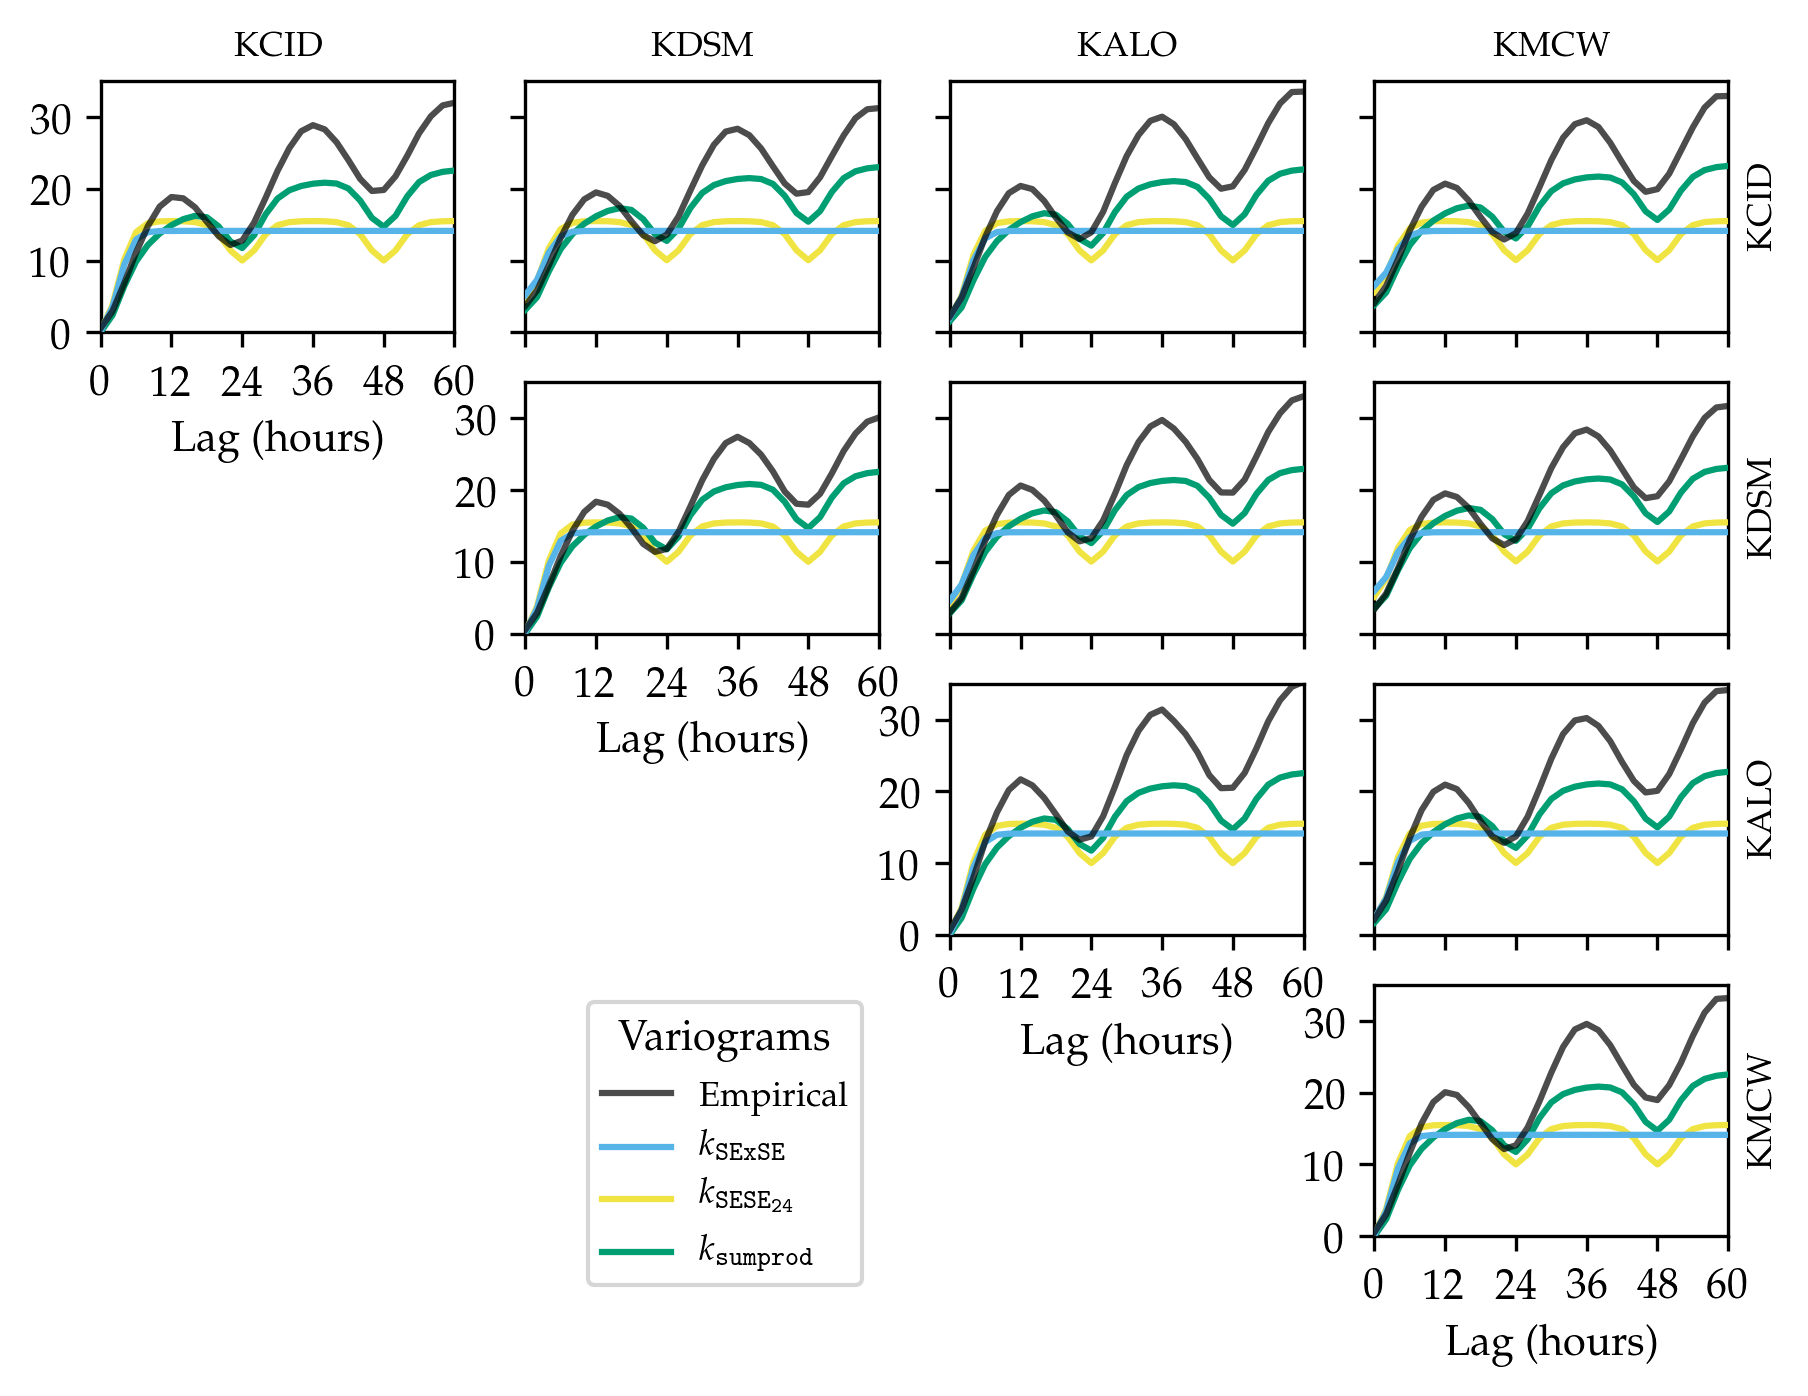

In [52]:
plot_variogram_grid(
    iowa[:isdSubset],
    (0,60), 0:12:60, 
    (0, 35), 0:10:30; 
    xdivider=1.0, xunit="hours", lastyticks=true, lastxticks=true)
plt.gcf()[:set_size_inches](7.0, 5.0)

plt.savefig("../figures/spatial_variogram.png", bbox_inches="tight")
plt.savefig("../figures/spatial_variogram.pdf", bbox_inches="tight")
;

# Map

In [30]:
Proj4.epsg[2794]

"+proj=lcc +lat_1=43.26666666666667 +lat_2=42.06666666666667 +lat_0=41.5 +lon_0=-93.5 +x_0=1500000 +y_0=1000000 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs"

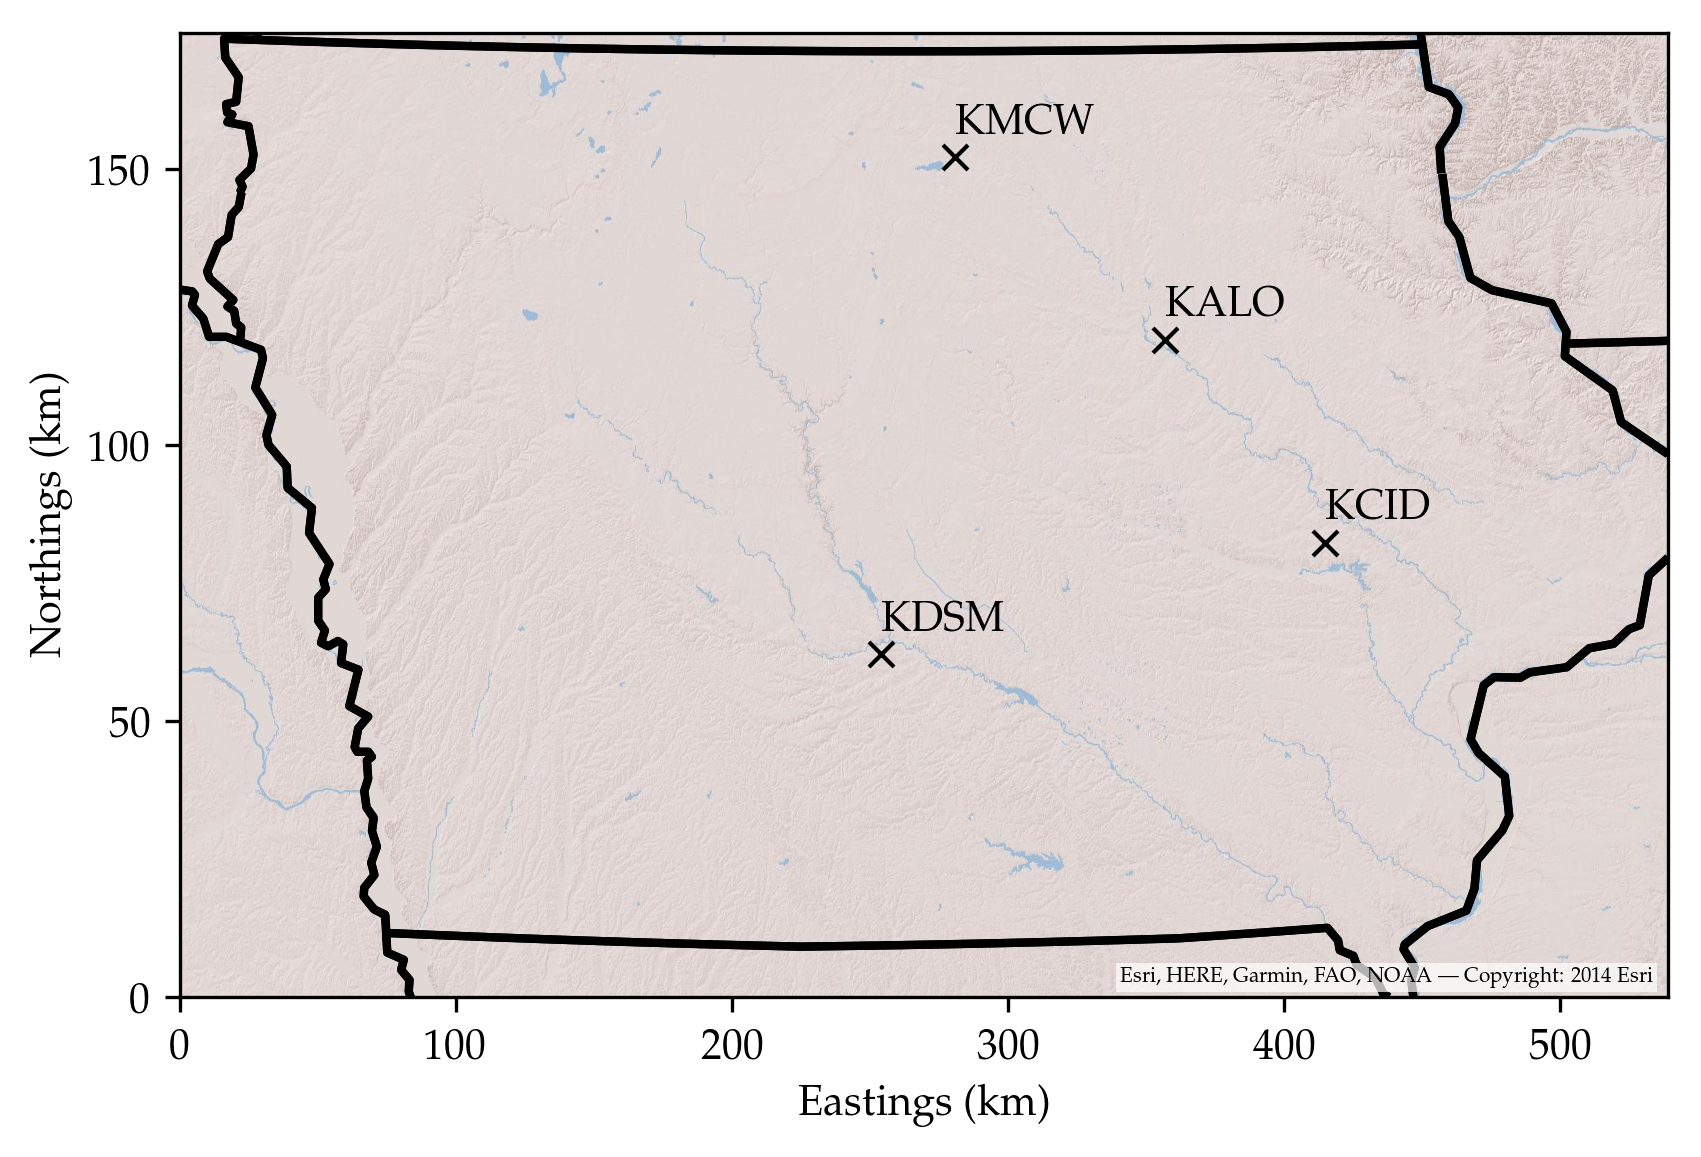

In [31]:
using PyCall
function plot_map(isdSubset)
    py"""
    from mpl_toolkits.basemap import Basemap
    import matplotlib.pyplot as plt

    map = Basemap(epsg=2794, llcrnrlon=-96.64,llcrnrlat=40.37, urcrnrlon=-90.13,urcrnrlat=43.51,
                 resolution="i", suppress_ticks=False)
    map.arcgisimage(service="World_Shaded_Relief", xpixels = 1500, verbose= True, zorder=1, dpi=100)
    map.drawstates(linewidth=2.0, zorder=2)
    """
    x_0 = py"map.projparams['x_0']"
    y_0 = py"map.projparams['y_0']"
    _xlim = plt.xlim()
    _ylim = plt.ylim()
    for i in 1:4
        plt.plot(isdSubset[i, :X_PRJ]-1500000+x_0, isdSubset[i, :Y_PRJ]-1000000+y_0, "x", color="black")
        plt.text(isdSubset[i, :X_PRJ]-1500000+x_0, isdSubset[i, :Y_PRJ]-1000000+y_0+5000, 
            isdSubset[i, :ICAO], 
            verticalalignment="bottom")
    end

    _xticks = plt.xticks()[1]
    plt.xticks(_xticks, [@sprintf("%.0f", x/1000) for x in _xticks])
    _yticks = plt.yticks()[1]
    plt.yticks(_xticks, [@sprintf("%.0f", x/1000) for x in _yticks])
    plt.xlabel("Eastings (km)")
    plt.ylabel("Northings (km)")
    plt.xlim(_xlim)
    plt.ylim(_ylim)
    plt.text(0.99, 0.01, "Esri, HERE, Garmin, FAO, NOAA | Copyright: 2014 Esri",
        horizontalalignment="right",
        verticalalignment="bottom",
        fontsize=5,
        bbox=Dict(:edgecolor=>"none",:facecolor=>"white", :alpha=>0.7, :pad=>1.0),
        transform = plt.gca()[:transAxes],)
end
plot_map(iowa[:isdSubset])
plt.savefig("../figures/Iowa_map.png", bbox_inches="tight")
plt.savefig("../figures/Iowa_map.pdf", bbox_inches="tight")
;

# trying to raise intercept

In [32]:
get_param_names(SEIso(0.0,0.0))

2-element Array{Symbol,1}:
 :ll
 :lσ

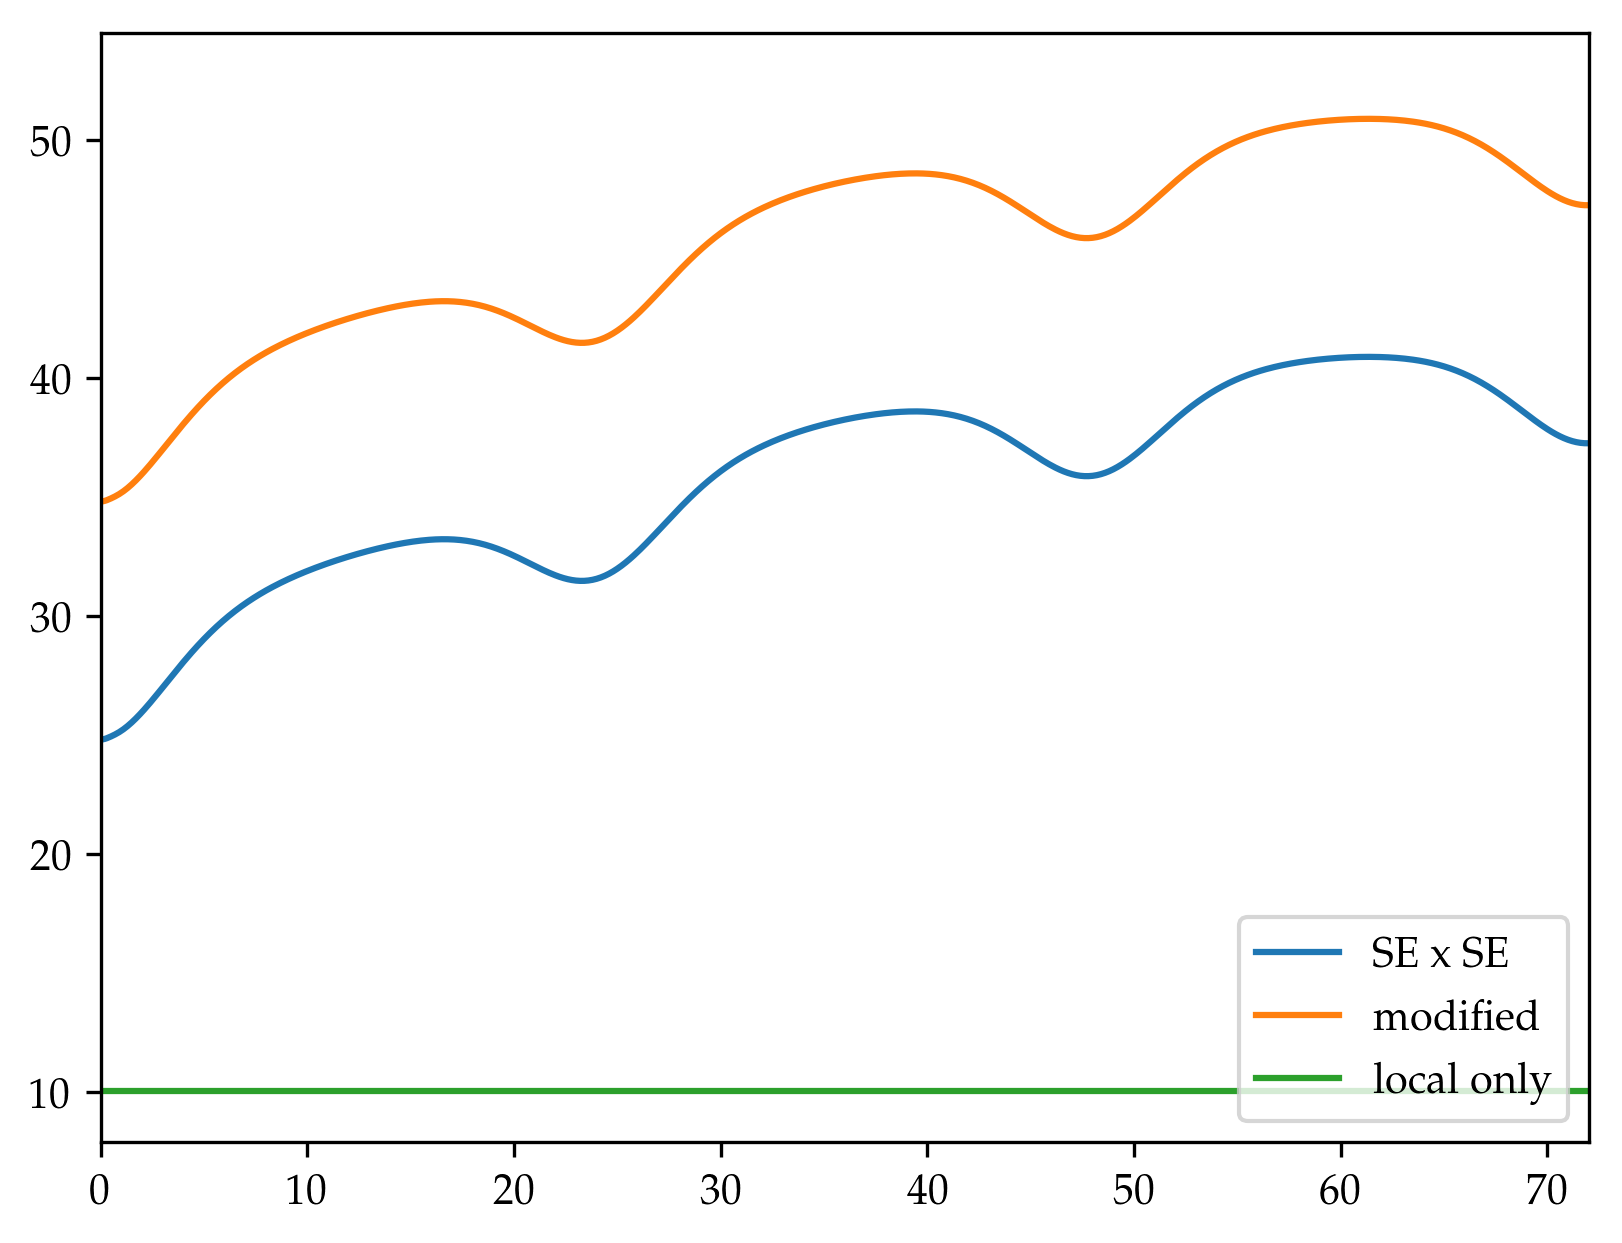

PyObject <matplotlib.legend.Legend object at 0x136d43470>

In [33]:
xx = 0.0:0.1:720.0
k_spatiotemporal = Masked(k_time, [1]) * Masked(k_spatial, [2,3]) #+ 
k_local = Masked(SEIso(0.0,log(√10.0)), [1]) * Masked(SEIso(0.0,0.0), [2,3])
gp_test_1 = GPE(;m=MeanZero(), k=k_spatiotemporal, logNoise=logNoise);
gp_test_2 = GPE(;m=MeanZero(), k=k_spatiotemporal+k_local, logNoise=logNoise);
gp_local = GPE(;m=MeanZero(), k=k_local, logNoise=logNoise);
d=1e5
plt.plot(xx, time_variog(gp_test_1, xx, d), label="SE x SE")
plt.plot(xx, time_variog(gp_test_2, xx, d), label="modified")
plt.plot(xx, time_variog(gp_local, xx, d), label="local only")
plt.xlim(0,24*3)
plt.legend(loc="lower right")

## Overlaid empirical variograms

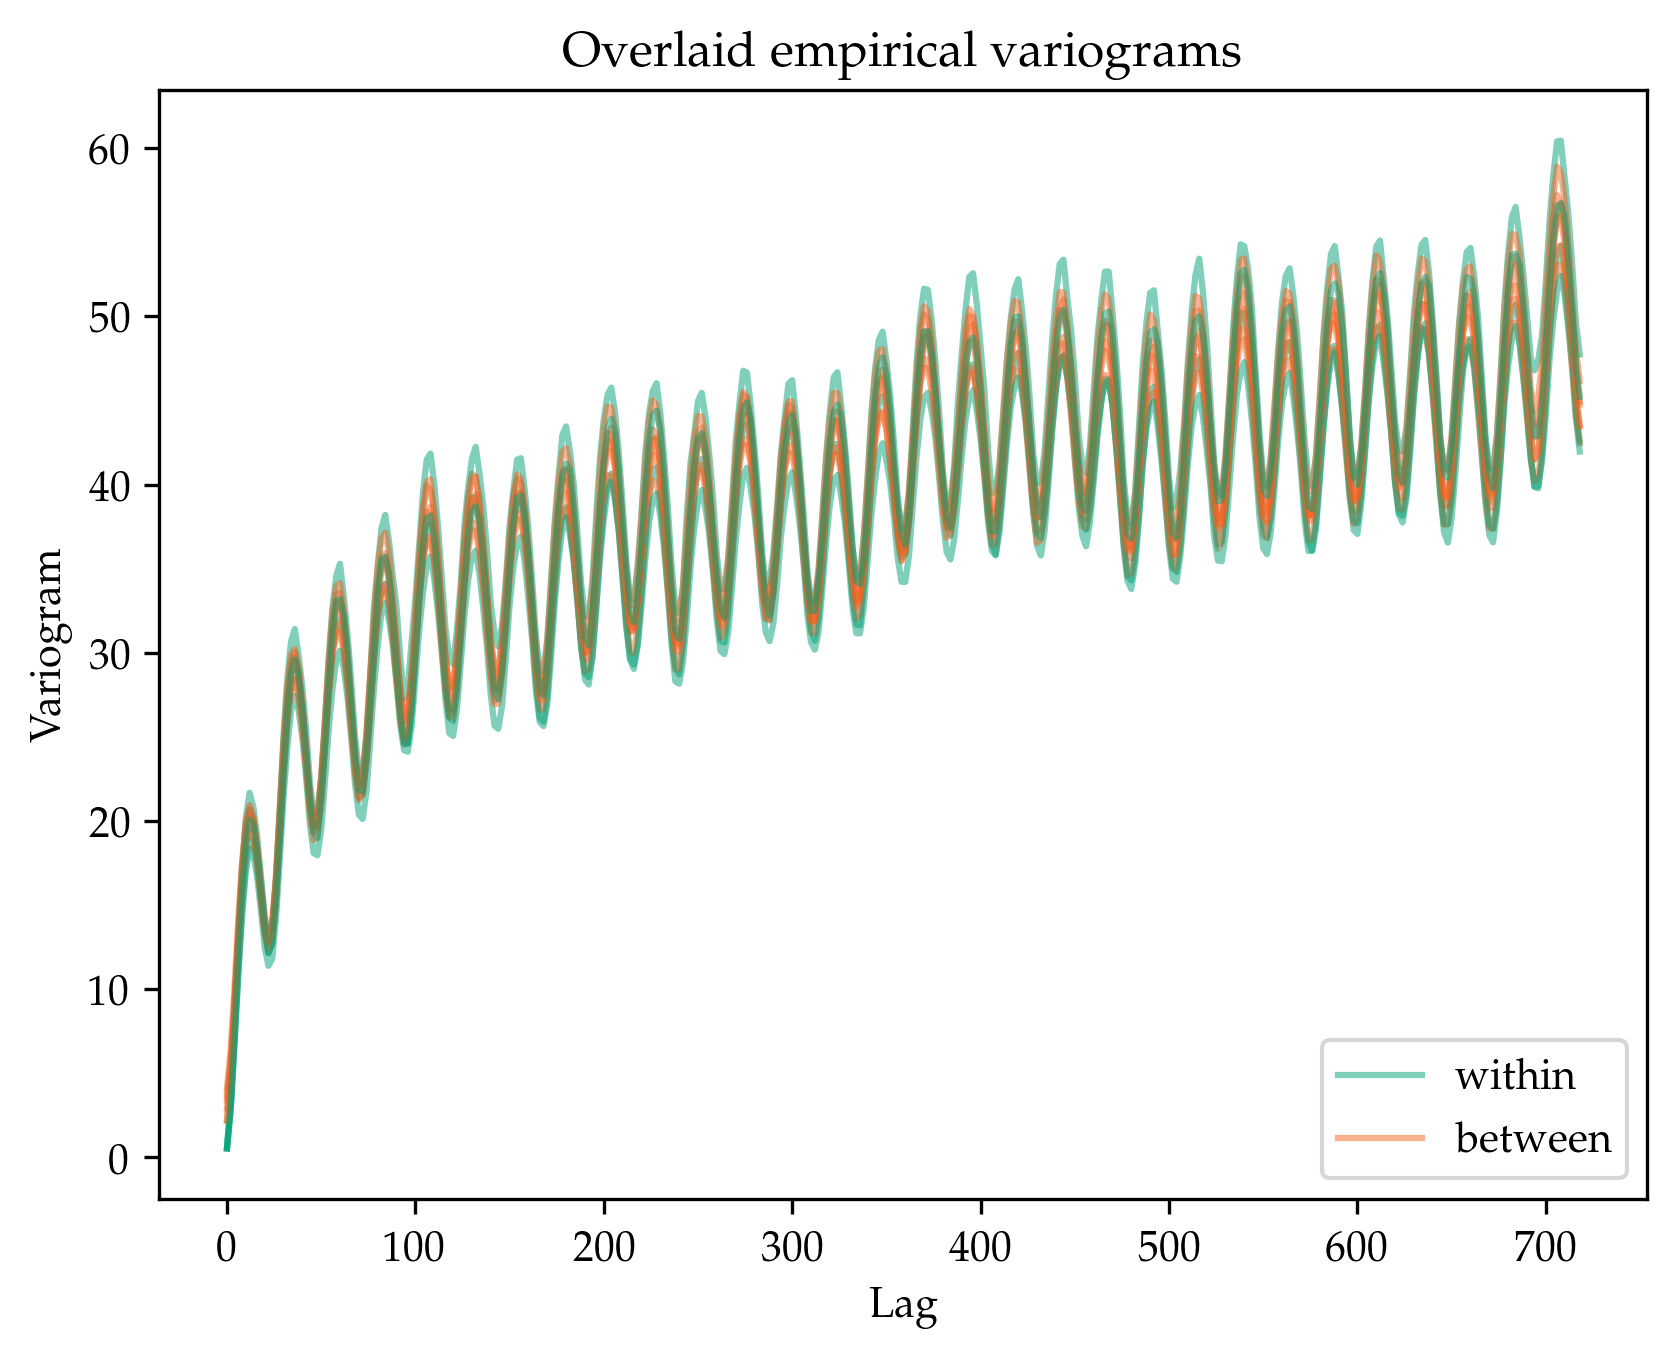

In [54]:
for station_i in 1:4
    for station_j in station_i:4
        v=all_cross_variogs[station_i,station_j]
        y = TempModel.variog(v)
        x = v.bins ./ Dates.Hour(1)
        label=""
        if station_i==station_j
            color="#00A076" # green
            if station_i==1
                label="within"
            end
        else
            color="#F16424" # orange
            if (station_i,station_j)==(1,2)
                label="between"
            end
        end
        plt.plot(x, y, color=color, linewidth=1.5, alpha=0.5, label=label)
        plt.xlabel("Lag")
        plt.ylabel("Variogram")
    end
end
plt.legend(loc="lower right")
plt.title("Overlaid empirical variograms")
;

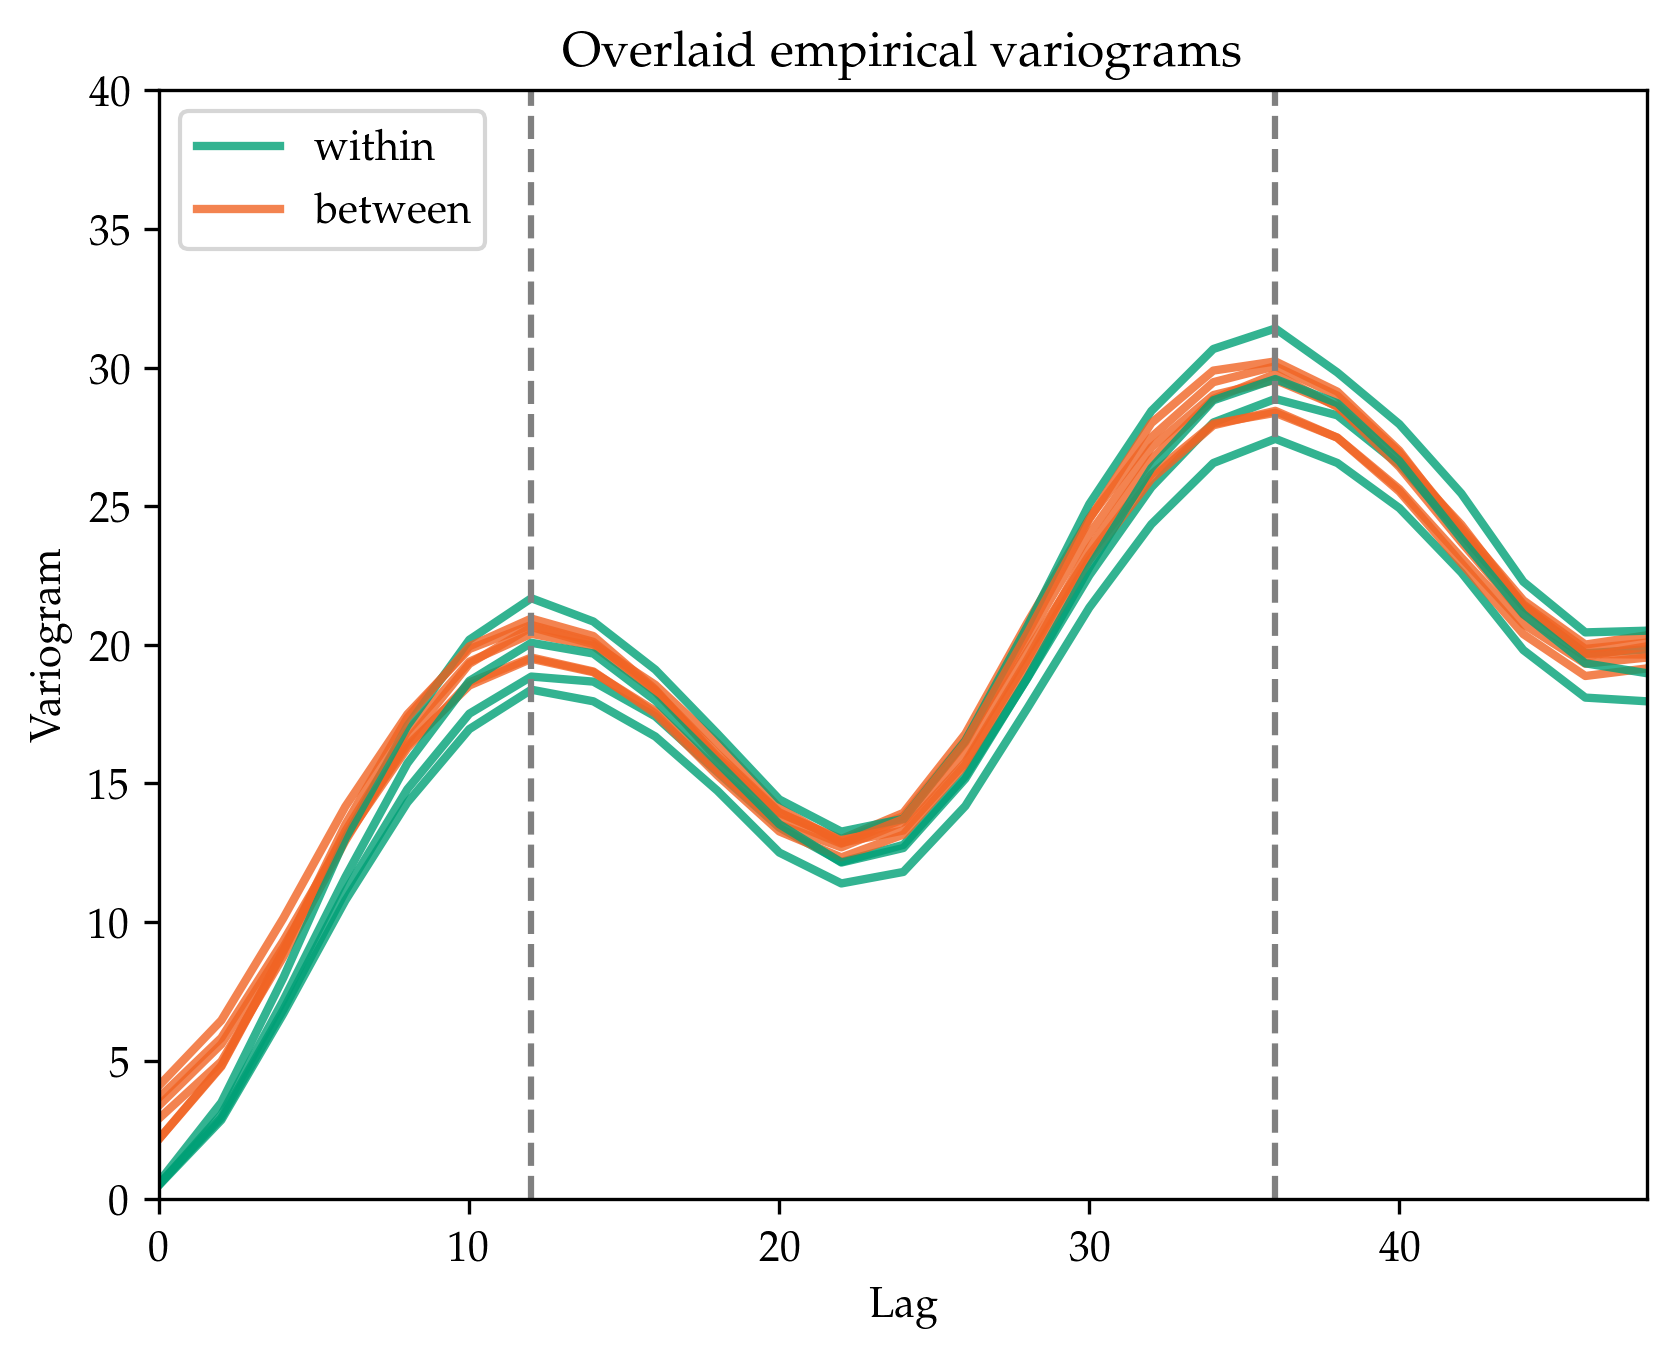

In [55]:
for station_i in 1:4
    for station_j in station_i:4
        v=all_cross_variogs[station_i,station_j]
        y = TempModel.variog(v)
        x = v.bins ./ Dates.Hour(1)
        label=""
        if station_i==station_j
            color="#00A076" # green
            if station_i==1
                label="within"
            end
        else
            color="#F16424" # orange
            if (station_i,station_j)==(1,2)
                label="between"
            end
        end
        plt.plot(x, y, color=color, linewidth=2, alpha=0.8, label=label)
        plt.xlabel("Lag")
        plt.ylabel("Variogram")
    end
end
for d in 0:10
    plt.axvline(12+d*24, linestyle="--", color="grey")
end
plt.legend(loc="upper left")
plt.xlim(0,48)
plt.ylim(0,40)
plt.title("Overlaid empirical variograms")
;

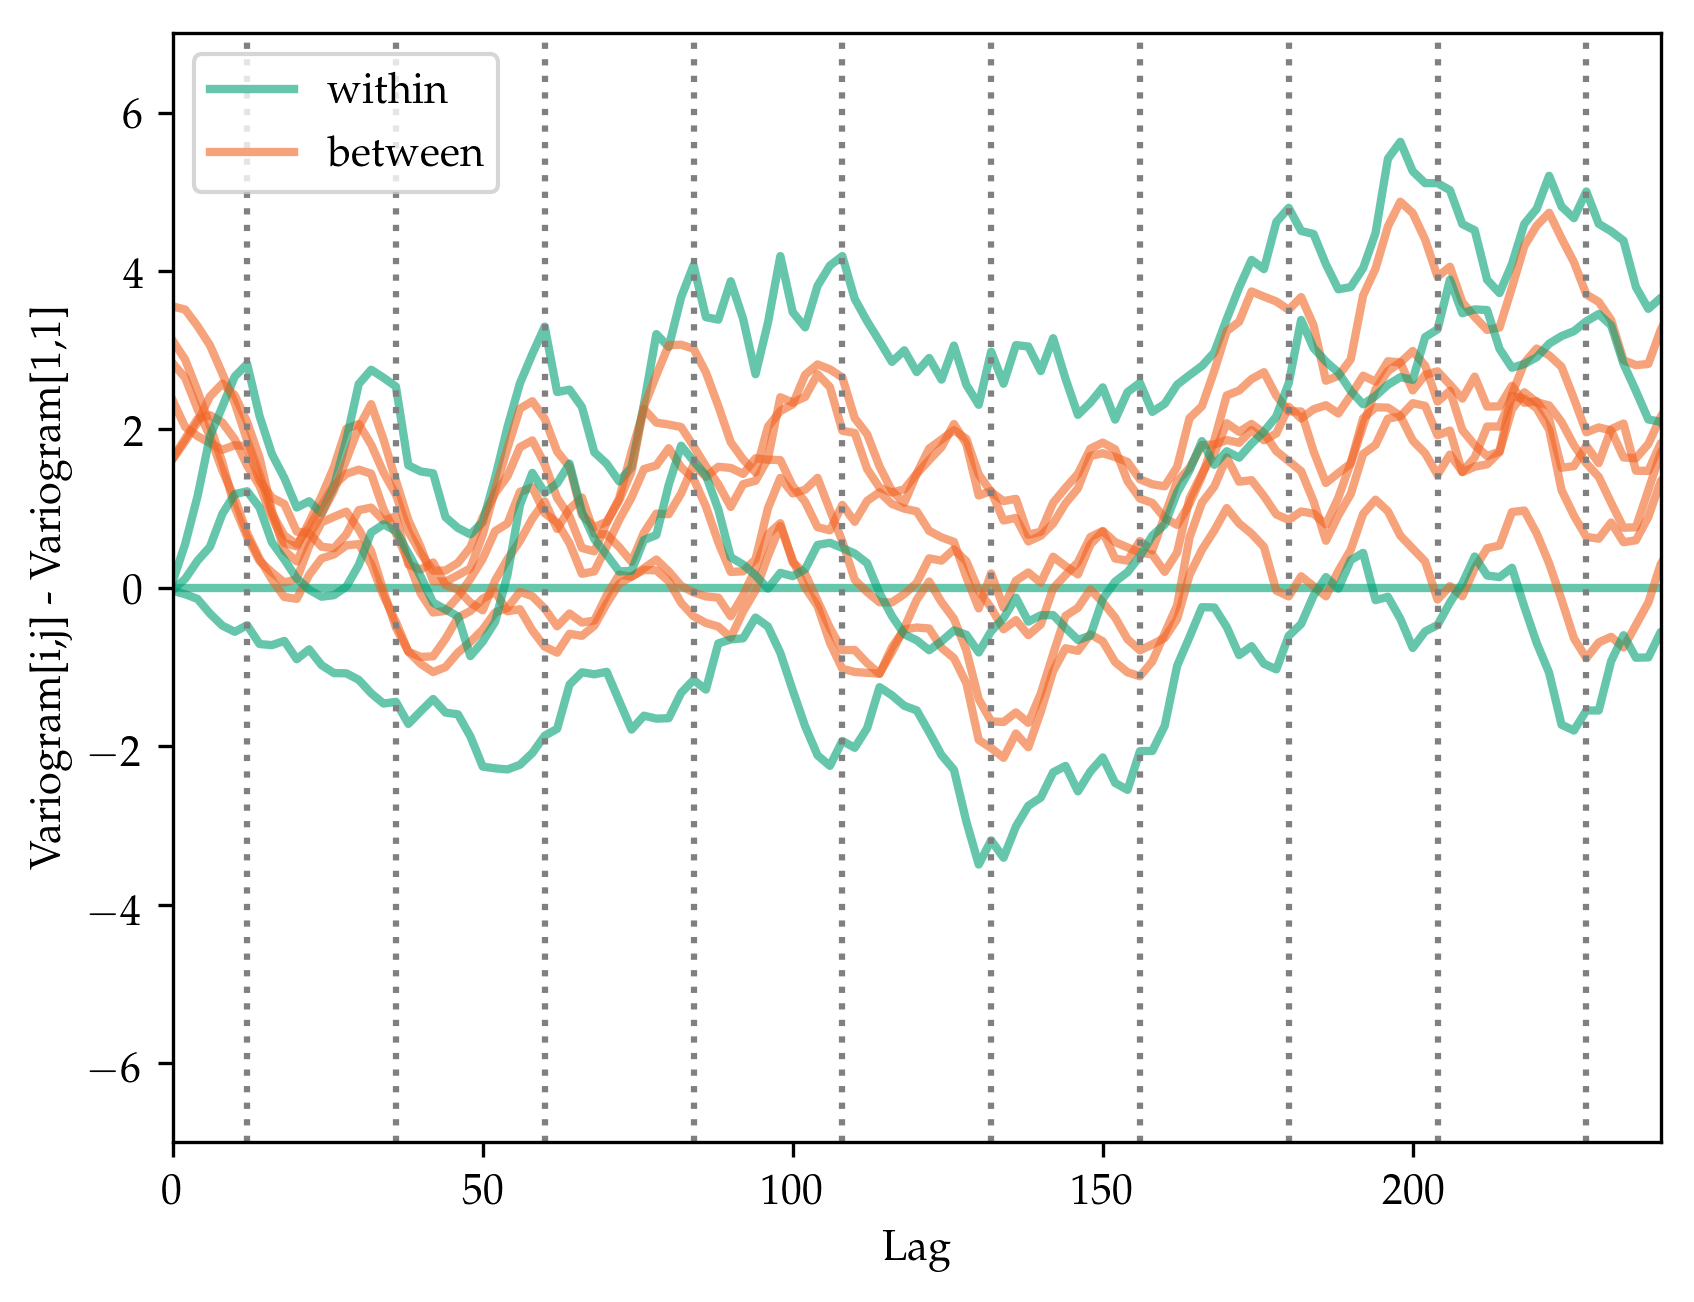

(-7, 7)

In [57]:
variog_11 = TempModel.variog(all_cross_variogs[1,1])
for station_i in 1:4
    for station_j in station_i:4
        v=all_cross_variogs[station_i,station_j]
        y = TempModel.variog(v).-variog_11
        x = v.bins ./ Dates.Hour(1)
        label=""
        if station_i==station_j
            color="#00A076" # green
            if station_i==1
                label="within"
            end
        else
            color="#F16424" # orange
            if (station_i,station_j)==(1,2)
                label="between"
            end
        end
        plt.plot(x, y, color=color, linewidth=2, alpha=0.6, label=label)
        plt.xlabel("Lag")
        plt.ylabel("Variogram[i,j] - Variogram[1,1]")
    end
end
for d in 0:30
    plt.axvline(12+d*24, linestyle=":", color="grey")
end
plt.legend(loc="upper left")
plt.xlim(0,24*10)
plt.ylim(-7,7)